Here, we examine parametric sensitivity of the structure model on a small simulated dataset

In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, data_utils, cavi_lib, plotting_utils
import vb_lib.structure_optimization_lib as s_optim_lib

from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
onp.random.seed(53453)

# Draw data

In [3]:
data_file = '../simulated_data/simulated_structure_data_nobs20_nloci50_npop4.npz'
data = np.load(data_file)

# the observations
g_obs = np.array(data['g_obs'], dtype = int)

n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

# the ground truth 
true_ind_admix_propn = data['true_ind_admix_propn']

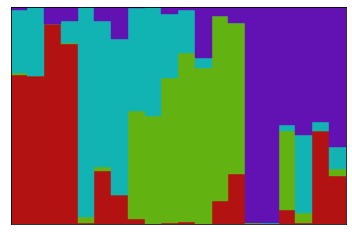

In [4]:
fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(true_ind_admix_propn, axarr);

In [5]:
g_obs.shape

(20, 50, 3)

Text(0.5, 0, 'individual')

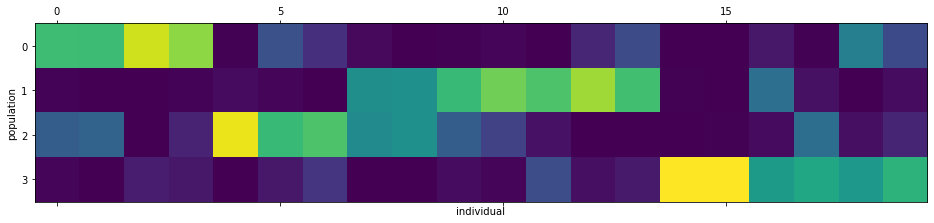

In [6]:
plt.matshow(true_ind_admix_propn.T)
plt.ylabel('population')
plt.xlabel('individual')

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [8]:
k_approx = 15

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
use_logitnormal_sticks = True

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (50, 15, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (20, 14) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (20, 14) (lb=0.0001, ub=inf)


## Initialize 

In [11]:
vb_params_dict = \
        s_optim_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                       prior_params_dict, 
                                       gh_loc, gh_weights,
                                       seed = 34221)

running NMF ...
running a few cavi steps for pop beta ...
done. Elapsed: 6.3613


Text(0.5, 0, 'individual')

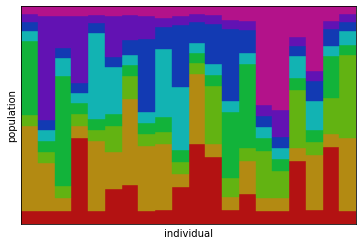

In [38]:
e_ind_admix = plotting_utils.get_vb_expectations(vb_params_dict, gh_loc, gh_weights)[0]

fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(e_ind_admix, axarr);

plt.ylabel('population')
plt.xlabel('individual')

# Optimize

In [13]:
from vb_lib.structure_optimization_lib import define_structure_objective
from bnpmodeling_runjingdev.optimization_lib import run_lbfgs

In [14]:
optim_objective, init_vb_free = \
    define_structure_objective(g_obs, vb_params_dict,
                        vb_params_paragami,
                        prior_params_dict,
                        gh_loc = gh_loc,
                        gh_weights = gh_weights, 
                        compile_hvp=False)


Compiling objective ...
Iter 0: f = 2649.80027944
Compiling grad ...
Compile time: 12.9354secs


In [15]:
out = run_lbfgs(optim_objective, init_vb_free)

vb_opt = out.x
vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)



Running L-BFGS-B ... 
Iter 0: f = 2649.80027944
Iter 1: f = 2598.72662706
Iter 2: f = 2429.98449137
Iter 3: f = 2215.09446543
Iter 4: f = 2172.51855120
Iter 5: f = 2128.22542216
Iter 6: f = 2109.04048577
Iter 7: f = 2097.68655302
Iter 8: f = 2084.22580864
Iter 9: f = 2062.57361836
Iter 10: f = 3118.52269311
Iter 11: f = 2055.83801356
Iter 12: f = 2038.38357807
Iter 13: f = 2019.12416478
Iter 14: f = 1981.92884239
Iter 15: f = 1950.52627517
Iter 16: f = 1932.19338483
Iter 17: f = 1917.96007706
Iter 18: f = 1908.09165508
Iter 19: f = 1898.29864704
Iter 20: f = 1887.97459621
Iter 21: f = 1880.04413778
Iter 22: f = 1872.53542887
Iter 23: f = 1868.79083225
Iter 24: f = 1864.02600484
Iter 25: f = 1860.06376122
Iter 26: f = 1853.29145336
Iter 27: f = 1848.12843031
Iter 28: f = 1845.52800570
Iter 29: f = 1843.39777796
Iter 30: f = 1842.52447319
Iter 31: f = 1841.95575664
Iter 32: f = 1841.60306624
Iter 33: f = 1841.31770810
Iter 34: f = 1841.05169490
Iter 35: f = 1840.85032325
Iter 36: f = 18

# Check out the fit

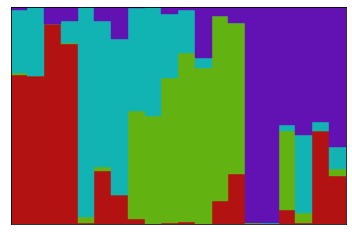

In [16]:
# truth 

fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(true_ind_admix_propn, axarr);

Text(0.5, 0, 'individual')

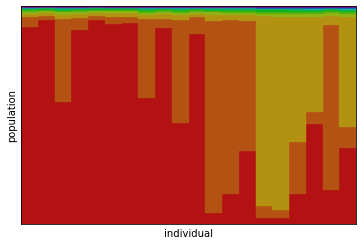

In [17]:
# estimated 

e_ind_admix = plotting_utils.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]

fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(e_ind_admix, axarr);

plt.ylabel('population')
plt.xlabel('individual')

# Define sensitivity object

In [19]:
# initial prior alpha
use_free_alpha = True
prior_alpha0 = prior_params_paragami['dp_prior_alpha'].flatten(prior_params_dict['dp_prior_alpha'], 
                                                              free = use_free_alpha)

In [20]:
# set up objective as function of vb params and prior param 

def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['dp_prior_alpha'] = alpha
    
    return structure_model_lib.get_kl(g_obs, vb_params_dict, _prior_params_dict,
                    gh_loc = gh_loc, gh_weights = gh_weights)


objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['dp_prior_alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])


In [21]:
objective_fun_free(vb_opt, prior_alpha0)

DeviceArray(1830.09680291, dtype=float64)

### Set up hessian solver

In [22]:
# define preconditioner
cg_precond = lambda v : get_mfvb_cov_matmul(v, vb_opt_dict,
                                            vb_params_paragami,
                                            return_info = True)
t0 = time.time()
_ = cg_precond(vb_opt)
print('preconditioner time: {:0.3}sec'.format(time.time() - t0))

preconditioner time: 1.28sec


In [23]:
vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
                                                        vb_opt,
                                                        prior_alpha0, 
                                                        cg_precond=cg_precond)


Compiling ...
Compile time: 96.5009sec



# Perturb alpha. Check results

In [24]:
# set new alpha 
new_alpha = np.array([5.])

prior_params_pert_dict = deepcopy(prior_params_dict)
prior_params_pert_dict['dp_prior_alpha'] = new_alpha


In [25]:
print('initial alpha, ', prior_params_dict['dp_prior_alpha'])
print('perturbed alpha, ', prior_params_pert_dict['dp_prior_alpha'])


initial alpha,  [3.]
perturbed alpha,  [5.]


In [26]:
# linear response prediction 
lr_vb_free_params = \
    vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami['dp_prior_alpha'].flatten(prior_params_pert_dict['dp_prior_alpha'], 
                                                        free = use_free_alpha))

print('l_inf diff: ', np.max(np.abs(lr_vb_free_params - vb_opt)))


l_inf diff:  0.9428052070353536


In [27]:
(lr_vb_free_params**2).mean()

DeviceArray(1.14782174, dtype=float64)

### reoptimize

In [28]:
new_init_dict = deepcopy(vb_opt_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [29]:
optim_objective_pert, _ = \
    define_structure_objective(g_obs, new_init_dict,
                        vb_params_paragami,
                        prior_params_pert_dict,
                        gh_loc = gh_loc,
                        gh_weights = gh_weights, 
                        compile_hvp=False)


Compiling objective ...
Iter 0: f = 2115.44799865
Compiling grad ...
Compile time: 12.126secs


In [30]:
out = run_lbfgs(optim_objective_pert, new_init_free)

vb_opt_pert = out.x
vb_pert_dict = vb_params_paragami.fold(vb_opt_pert, free = True)


Running L-BFGS-B ... 
Iter 0: f = 2115.44799865
Iter 1: f = 2104.14880262
Iter 2: f = 2073.47853355
Iter 3: f = 2067.68100677
Iter 4: f = 2063.28170527
Iter 5: f = 2062.69251538
Iter 6: f = 2062.54864924
Iter 7: f = 2062.40393249
Iter 8: f = 2062.28681491
Iter 9: f = 2062.14343250
Iter 10: f = 2062.11122890
Iter 11: f = 2062.09129766
Iter 12: f = 2062.08030972
Iter 13: f = 2062.06392153
Iter 14: f = 2062.05459805
Iter 15: f = 2062.04619292
Iter 16: f = 2062.03606676
Iter 17: f = 2062.04002996
Iter 18: f = 2062.03249309
Iter 19: f = 2062.03019611
Iter 20: f = 2062.02759933
Iter 21: f = 2062.02490481
Iter 22: f = 2062.02596072
Iter 23: f = 2062.02372549
Iter 24: f = 2062.02251645
Iter 25: f = 2062.02206069
Iter 26: f = 2062.02171998
Iter 27: f = 2062.02143219
Iter 28: f = 2062.02119790
Iter 29: f = 2062.02110327
Iter 30: f = 2062.02102016
Iter 31: f = 2062.02094946
Iter 32: f = 2062.02089940
Iter 33: f = 2062.02088141
Iter 34: f = 2062.02087086
Iter 35: f = 2062.02085962
Iter 36: f = 20

### compare

In [31]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')


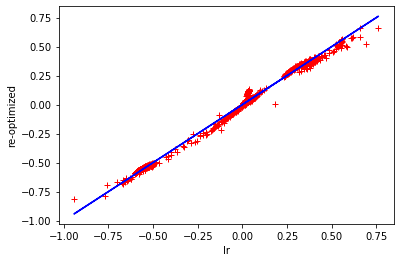

In [32]:
# compare free parameters
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

In [33]:
key = jax.random.PRNGKey(1)

def get_e_num_pred_clusters(vb_params_dict): 
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return structure_model_lib.get_e_num_pred_clusters(stick_means, stick_infos, gh_loc, gh_weights, 
                                                            key, n_samples = 10000)

In [34]:
print('init number of cluster: ', get_e_num_pred_clusters(vb_opt_dict))
print('pert number of cluster: ', get_e_num_pred_clusters(vb_pert_dict))
print('lr number of cluster: ', get_e_num_pred_clusters(vb_params_paragami.fold(lr_vb_free_params, 
                                                                                free = True)))

init number of cluster:  3.741626053282419
pert number of cluster:  4.462039570549483
lr number of cluster:  4.441917962805207


# Fit for a range of alpha

In [35]:
alpha_list = np.arange(1, 8)

In [36]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    # set new prior
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha
    
    # set new objective 
    optim_objective_pert, new_init_free = \
        define_structure_objective(g_obs, new_init_dict,
                            vb_params_paragami,
                            prior_params_pert_dict,
                            gh_loc = gh_loc,
                            gh_weights = gh_weights, 
                            compile_hvp=False)

    out = run_lbfgs(optim_objective_pert, new_init_free)
        
    return out.x


In [37]:
print('alphas: ', alpha_list)

alphas:  [1 2 3 4 5 6 7]


In [38]:
vb_pert_list = []
for alpha in alpha_list: 
    print('\n re-optimzing with alpha = ', alpha)
    
    vb_pert_list.append(refit_with_alpha(alpha, new_init_dict))



 re-optimzing with alpha =  1
Compiling objective ...
Iter 0: f = 1544.74560716
Compiling grad ...
Compile time: 11.8011secs

Running L-BFGS-B ... 
Iter 0: f = 1544.74560716
Iter 1: f = 1533.11537388
Iter 2: f = 1463.28414154
Iter 3: f = 1484.32179298
Iter 4: f = 1440.61617755
Iter 5: f = 1431.78350653
Iter 6: f = 1427.14033788
Iter 7: f = 1422.69873379
Iter 8: f = 1418.97014838
Iter 9: f = 1419.84462896
Iter 10: f = 1418.21987180
Iter 11: f = 1417.73364550
Iter 12: f = 1417.64418529
Iter 13: f = 1417.48536980
Iter 14: f = 1417.44620095
Iter 15: f = 1417.32443186
Iter 16: f = 1417.28603798
Iter 17: f = 1417.22674004
Iter 18: f = 1417.16937221
Iter 19: f = 1417.23046525
Iter 20: f = 1417.14878681
Iter 21: f = 1417.12475738
Iter 22: f = 1417.11044127
Iter 23: f = 1417.09142571
Iter 24: f = 1417.09780747
Iter 25: f = 1417.08365859
Iter 26: f = 1417.07503977
Iter 27: f = 1417.07004484
Iter 28: f = 1417.06665231
Iter 29: f = 1417.06429429
Iter 30: f = 1417.06250422
Iter 31: f = 1417.061556

# Check free parameters

In [39]:
lr_list = []

for alpha in alpha_list: 
    
    # set alpha 
    new_alpha = np.array([alpha])
    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami['dp_prior_alpha'].flatten(prior_params_pert_dict['dp_prior_alpha'], 
                                                        free = use_free_alpha)))


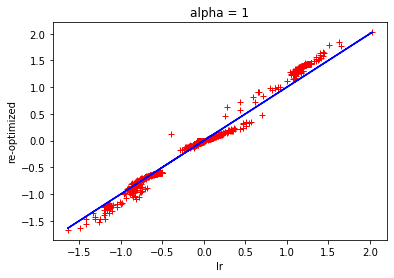

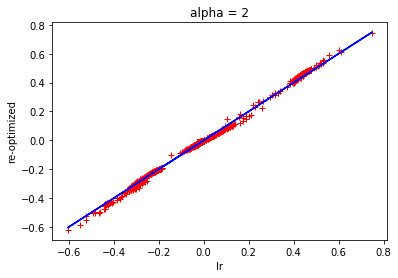

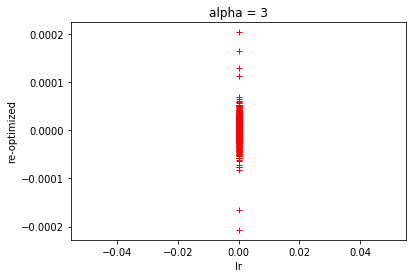

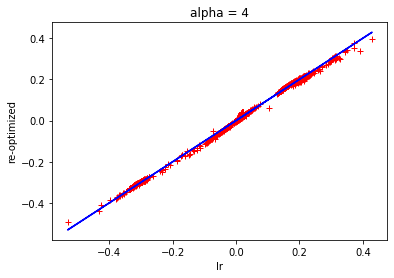

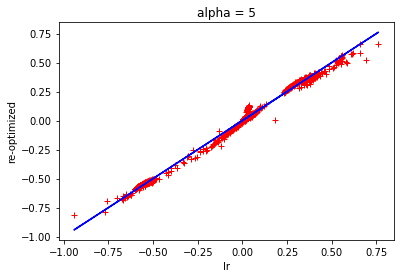

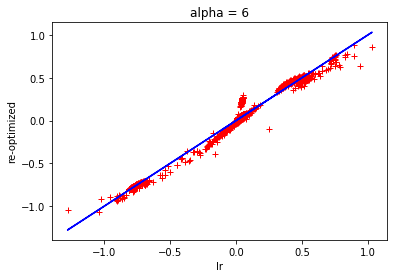

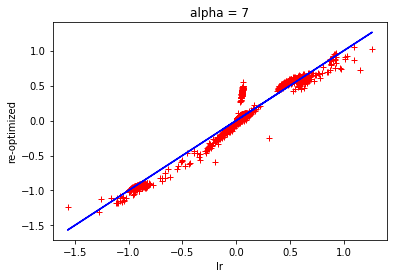

In [40]:
for i in range(len(alpha_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('alpha = {}'.format(alpha_list[i]))


# Number of clusters

In [41]:
import numpy as onp

In [42]:
lr_e_num_clusters_vec = onp.zeros(len(alpha_list))
refit_e_num_clusters_vec = onp.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    
    # get dictionaries
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)
    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    
    # get posterior expectations
    pert_e_ind_admix, pert_e_pop_freq = plotting_utils.get_vb_expectations(pert_dict, gh_loc, gh_weights)
    lr_e_ind_admix, lr_e_pop_freq = plotting_utils.get_vb_expectations(lr_dict, gh_loc, gh_weights)
    
    # get number of clusters
    refit_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(pert_e_ind_admix)
    lr_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(lr_e_ind_admix)


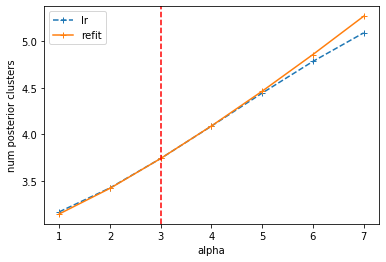

In [43]:
plt.plot(alpha_list, lr_e_num_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['dp_prior_alpha'], color = 'red', linestyle = 'dashed')